# Airfoil Self Noise

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[0]
sys.path.append(str(path_root))
sys.path.append(str(Path(os.getcwd()).parents[1]))

%reload_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
import optax
import equinox as eqx
from jax.lib import xla_bridge

In [5]:
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, mse, mae, train_test_split
from steinRF.baselines import build_svgp, build_train_svgp, svgp_predict, svgp_cross_val, svgp_nlpd
from steinRF.stein.targets import TFTarget
from steinRF.gp.models import *

In [6]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data Preparation

In [7]:
key = jax.random.PRNGKey(0)

In [8]:
airfoil = pd.read_csv("airfoil.csv")
X_scaler = MinMaxScaler()
y_scaler = StandardScaler()
airfoil[
    ['frequency', 'angle', 'chord_length', 'velocity', 'thickness']
] = X_scaler.fit_transform(airfoil.drop(columns=["sound_pressure"]))
airfoil['sound_pressure'] = y_scaler.fit_transform(airfoil[['sound_pressure']])

X = jnp.array(airfoil.drop(columns=['sound_pressure']))
y = jnp.array(airfoil['sound_pressure'])
X_train, X_val, y_train, y_val = train_test_split(key, X, y, test_size=0.1)
d = X_train.shape[1]

## Hyperparameter Optimization

In [9]:
# total settings
diag_min, diag_max = 1e-4, 3e-1
epoch_min, epoch_max = 500, 5000
lr_min, lr_max = 1e-3, 4e-1
alpha_min, alpha_max = 0., 3.
q_min, q_max = 2, 10
s_vals = [0, 0.5, 1, 2]


# --------------------------------- Sparse Variational GP -------------------------------- #
def _svgp_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        # lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
        lr = trial.suggest_float("lr", 5e-4, 2e-1, log=True)  # modified due to numerical stability issues
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = svgp_cross_val(key, X, y, cv_params)
    return cross_val_acc


# ---------------------------------- RFF GP - RBF Kernel --------------------------------- #
def rff_rbf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff_rbf, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- RFF BASIC -------------------------------------- #
def rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- STEIN RFF -------------------------------------- #
def srf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)
    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'lr_gd': lr_gd, 'diag': diag, 'alpha': alpha, 
        's': s, **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_srf, key, X, y, cv_params)
    return cross_val_acc


# ------------------------------------ MARGINAL KERNEL ----------------------------------- #
def mix_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, 'kernel': 'rbf', **params
    }

    # run cross val
    n_folds = params.pop('n_folds', 5)
    cross_val_acc = gp_cross_val(build_train_mix_rff, key, X, y, cv_params, n_folds=n_folds)
    return cross_val_acc


### Run Optimization

In [11]:
n_trials = 30
R = 100
hparams = {}

#### Sparse-Variational GP

In [ ]:
# svgp = build_train_svgp(key, X, y, R=R, diag=1e-2, epochs=1000, lr=0.01, from_data=True)[0]
svgp_study = run_hyperopt(
    _svgp_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, diag=1e-2, from_data=True
)
hparams["svgp"] = svgp_study.best_params

#### RFF with RBF

In [ ]:
rff_rbf_study = run_hyperopt(
    rff_rbf_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000
)
hparams["rff_rbf"] = rff_rbf_study.best_params

#### Basic RFF GP

In [ ]:
rff_study = run_hyperopt(
    rff_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, from_data=False
)
hparams["rff"] = rff_study.best_params

[I 2024-02-09 23:55:11,152] A new study created in memory with name: no-name-6de4edfe-1443-4eb5-b9bd-ed9889e3ee91


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-02-09 23:55:33,377] Trial 0 finished with value: 0.5337815426485755 and parameters: {'diag': 0.23117721247952264, 'lr': 0.012616880698776459}. Best is trial 0 with value: 0.5337815426485755.
[I 2024-02-09 23:55:50,713] Trial 1 finished with value: 0.7655005702731059 and parameters: {'diag': 0.003058623708843389, 'lr': 0.03872129317018847}. Best is trial 0 with value: 0.5337815426485755.
[I 2024-02-09 23:56:07,897] Trial 2 finished with value: 0.771694846539692 and parameters: {'diag': 0.16403098877679467, 'lr': 0.0016769902480610612}. Best is trial 0 with value: 0.5337815426485755.
[I 2024-02-09 23:56:25,057] Trial 3 finished with value: 0.13597245817226222 and parameters: {'diag': 0.07508191623541309, 'lr': 0.2509584122789611}. Best is trial 3 with value: 0.13597245817226222.
[I 2024-02-09 23:56:42,234] Trial 4 finished with value: 0.9748870104459337 and parameters: {'diag': 0.009076210871469318, 'lr': 0.01221113867201213}. Best is trial 3 with value: 0.13597245817226222.
[I 2

#### Stein Random Features

In [ ]:
srf_study = run_hyperopt(
    srf_cross_val, key, X_train, y_train, n_trials=50, R=R, epochs=1000, from_data=False,
    gd_params=lambda t: [t.kernel.transform.scale]
)
hparams["srf"] = srf_study.best_params

#### Mixture SRFR

In [12]:
prior = TFTarget(tfd.Normal(jnp.zeros(d), jnp.ones(d) * 3))
mix_rff_study = run_hyperopt(
    mix_rff_cross_val, key, X_train, y_train, n_trials=30, R=R, epochs=1000, from_data=False, prior=prior,
    gd_params=lambda t: [t.kernel.transform.scale], q=6
)

[I 2024-06-01 15:10:07,142] A new study created in memory with name: no-name-623d07ee-d65f-4e3c-9127-89fc30f27656


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-06-01 15:11:38,201] Trial 0 finished with value: 0.12828999251727416 and parameters: {'diag': 0.011767222542662098, 'lr': 0.08527898265770131, 'lr_gd': 0.3599433976231474, 'alpha': 2.0, 's': 2}. Best is trial 0 with value: 0.12828999251727416.
[I 2024-06-01 15:13:05,738] Trial 1 finished with value: 0.39172017381657326 and parameters: {'diag': 0.00043303547355933987, 'lr': 0.001969410980662396, 'lr_gd': 0.007804871375986244, 'alpha': 1.4000000000000001, 's': 0}. Best is trial 0 with value: 0.12828999251727416.
[I 2024-06-01 15:14:33,607] Trial 2 finished with value: 0.2663443338720281 and parameters: {'diag': 0.004108478914175363, 'lr': 0.01887454290348518, 'lr_gd': 0.08193831084112022, 'alpha': 0.4, 's': 0}. Best is trial 0 with value: 0.12828999251727416.
[I 2024-06-01 15:16:01,556] Trial 3 finished with value: 0.0899078294387594 and parameters: {'diag': 0.08165438550284168, 'lr': 0.22206865848168347, 'lr_gd': 0.007054209875928406, 'alpha': 0.2, 's': 0}. Best is trial 3 with 

## Define and Run Experiment

### Definition

In [9]:
def experiment_run(exp_key, X, y, scaler, params, R, restarts=1):    
    # split data
    X_tr, X_test, y_tr, y_test = train_test_split(exp_key, X, y, test_size=0.1)

    ############ SVGP ############
    svgp, _ = build_train_svgp(exp_key, X_tr, y_tr, R=R, **params["svgp"])
    svgp_preds, svgp_sd = svgp_predict(svgp, X_test)
    svgp_metrics = metric_model(y_test, svgp_preds, svgp_sd, scaler=scaler)
    svgp_metrics = jnp.concatenate([svgp_metrics, jnp.atleast_1d(svgp_nlpd(svgp, X_test, y_test))])

    ############ RFF RBF ############
    rff_rbf_gp, _ = build_train_rff_rbf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff_rbf"])
    rff_rbf_preds, rff_rbf_sd = rff_rbf_gp.condition(y_tr, X_test)
    rff_rbf_metrics = metric_model(y_test, rff_rbf_preds, rff_rbf_sd, scaler=scaler)
    rff_rbf_metrics = jnp.concatenate([
        rff_rbf_metrics, jnp.atleast_1d(rff_rbf_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF ############
    rff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff"])
    rff_preds, rff_sd = rff_gp.condition(y_tr, X_test)
    rff_metrics = metric_model(y_test, rff_preds, rff_sd, scaler=scaler)
    rff_metrics = jnp.concatenate([
        rff_metrics, jnp.atleast_1d(rff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ RFF-Q ############
    # RFF with the equilvalent number of R as the computational complexity of the mixture.
    q = params["mix_rff"]["q"]
    R_equiv_q = int((q * R**3)**(1/3))
    qrff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R_equiv_q, restarts=restarts, **params["rff"])
    qrff_preds, qrff_sd = qrff_gp.condition(y_tr, X_test)
    qrff_metrics = metric_model(y_test, qrff_preds, qrff_sd, scaler=scaler)
    qrff_metrics = jnp.concatenate([
        qrff_metrics, jnp.atleast_1d(qrff_gp.nlpd(y_tr, X_test, y_test))
    ])

    ############ SRF ############
    srf_gp, _ = build_train_srf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["srf"])
    srf_preds, srf_sd = srf_gp.condition(y_tr, X_test)
    srf_metrics = metric_model(y_test, srf_preds, srf_sd, scaler=scaler)
    srf_metrics = jnp.concatenate([
        srf_metrics, jnp.atleast_1d(srf_gp.nlpd(y_tr, X_test, y_test))
    ])    

    ############ MIX ############
    mix_gp, _ = build_train_mix_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["mix_rff"])
    mix_preds, mix_sd = mix_gp.condition(y_tr, X_test)
    mix_metrics = metric_model(y_test, mix_preds, mix_sd, scaler=scaler)
    mix_metrics = jnp.concatenate([
        mix_metrics, jnp.atleast_1d(mix_gp.nlpd(y_tr, X_test, y_test))
    ])

    metrics = {
        "seed": exp_key[1],
        "svgp": svgp_metrics,
        "rff_rbf": rff_rbf_metrics,
        "rff": rff_metrics,
        "qrff": qrff_metrics,
        "srf": srf_metrics,
        "mix": mix_metrics,
    }

    return metrics

In [10]:
def multi_run(multi_key, X, y, scaler, params, R, n_runs=10):
    metrics = []
    run_keys = jax.random.split(multi_key, n_runs)

    for i in range(n_runs):
        print(f"Running experiment {i+1} of {n_runs}")
        run_res = experiment_run(run_keys[i], X, y, scaler, params, R)
        metrics.append(run_res)
        print(run_res)
    
    return metrics

### Run

In [11]:
# parameters
KEY, subkey = jax.random.split(jax.random.PRNGKey(42))
params = {
    "svgp": {'epochs': 3500, 'lr': 0.00505763686973616, 'diag': 0.01, 'from_data': True},
    "rff_rbf": {'diag': 0.01058284383544528, 'lr': 0.3783299029837165, 'epochs': 1000, 'init_ls': True},
    "rff": {'diag': 0.020647596678603598, 'lr': 0.2147972751341417, 'epochs': 1000, 'from_data': False, 'init_ls': True},
    "srf": {
        'diag': 0.0016445011018499439, 'lr': 0.2392587812789433, 'lr_gd': 0.3831620299411177, 'alpha': 1.6, 's': 1,
        'epochs': 1000, 'from_data': False, 'gd_params': lambda t: [t.kernel.transform.scale], 'init_ls': True
    },
    "mix_rff": {  # not done
        'diag': 0.00909362196296053, 'lr': 0.19497338128923844, 'lr_gd': 0.002671371172348661, 'alpha': 0., 's': 0.5,
        # 'diag': 0.0016445011018499439, 'lr': 0.14002311333326806, 'lr_gd': 0.29379290342643566, 'alpha': 1.6, 's': 2, # old params pre update
        'q': 6, 'epochs': 1000, 'from_data': False, 'init_ls': True, 'gd_params': lambda t: [t.kernel.transform.scale],
        'prior': TFTarget(tfd.Normal(jnp.zeros(d), jnp.ones(d) * 3))
    },
}

In [22]:
# experiment_run(subkey, X_val, y_val, y_scaler, params, R=100)
res = multi_run(KEY, X, y, y_scaler, params, R=100, n_runs=10)

Running experiment 1 of 10
{'seed': Array(1898466860, dtype=uint32), 'svgp': Array([5.92674959e+00, 1.75257079e+00, 9.73333359e-01, 2.54872910e-04,
       2.96338342e+02], dtype=float64), 'rff_rbf': Array([6.62735759e+00, 1.76150146e+00, 5.20000041e-01, 1.35202504e-03,
       3.95625291e+02], dtype=float64), 'rff': Array([ 8.48601482e+00,  1.50033341e+00,  8.53333354e-01, -1.47083111e-03,
        3.00956977e+02], dtype=float64), 'qrff': Array([ 8.24703510e+00,  1.71169120e+00,  8.06666672e-01, -1.48201567e-03,
        2.11203095e+02], dtype=float64), 'srf': Array([ 8.36743380e+00,  1.52768362e+00,  3.60000014e-01, -8.04696678e-04,
        3.00549463e+03], dtype=float64), 'mix': Array([3.21675471e+00, 1.21875088e+00, 9.66666698e-01, 6.18804910e-04,
       3.10678844e+02], dtype=float64)}
Running experiment 2 of 10
{'seed': Array(82708574, dtype=uint32), 'svgp': Array([ 5.64094866e+00,  1.65660343e+00,  9.33333337e-01, -3.48002324e-04,
        4.66711702e+02], dtype=float64), 'rff_rbf': 

In [23]:
res_df = []
for exp in res:
    res_df.extend([[k, *v.tolist()] for k,v in exp.items() if k != "seed"])
res_df = pd.DataFrame(res_df, columns=["model", "mse", "mae", "cal", "z", "nlpd"])
res_df.to_csv("results_cr.csv", index=False)

## Evaluate

In [24]:
res_df = pd.read_csv("results_cr.csv")

names = {
    "rff": "SSGP",
    "rff_rbf": "SSGP-RBF",
    "svgp": "SVGP",
    "srf": "SSGP-SVGD",
    "qrff": "SSGP-$R^*$",
    "mix": "M-SRFR (Ours)",
}

res_df["model"] = res_df["model"].apply(lambda x: names[x])
res_df["rmse"] = np.sqrt(res_df["mse"])
res_df["log_mse"] = np.log(res_df["mse"])

In [26]:
sum_df = res_df.groupby("model").agg(["mean", "std"])
sum_df.columns = sum_df.columns.map(lambda x: '_'.join(x) if isinstance(x, tuple) else x)
sum_df = sum_df.sort_values("rmse_mean", ascending=True).reset_index()
sum_df[['model', 'rmse_mean', 'rmse_std', "nlpd_mean", "nlpd_std"]]

,model,rmse_mean,rmse_std,nlpd_mean,nlpd_std
0,M-SRFR (Ours),1.879524,0.265701,454.259234,134.489198
1,SVGP,2.357752,0.239538,487.041690,203.362357
2,SSGP,2.405319,0.527697,216.017163,159.936850
3,SSGP-SVGD,2.501563,0.585921,4166.615131,2885.481037
4,SSGP-$R^*$,2.540724,1.085932,213.404801,369.557929
5,SSGP-RBF,2.901692,0.604311,780.534114,457.032398


Text(0.5, 1.0, 'Airfoil UCI Dataset Error')

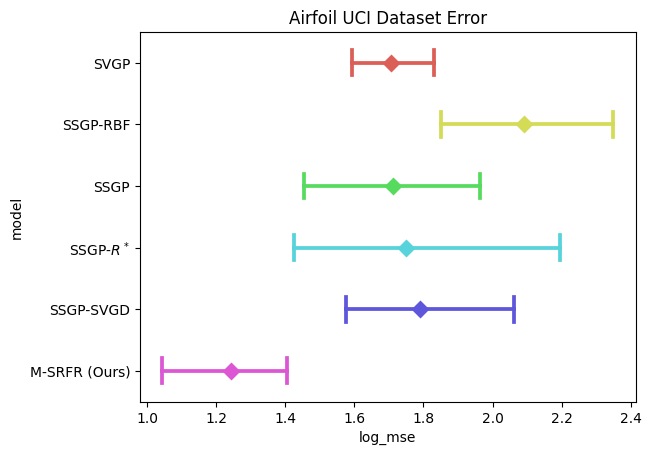

In [27]:
unique_models = res_df["model"].unique()
colors = sns.color_palette("hls", len(unique_models))

pointplot = sns.pointplot(
    data=res_df, x="log_mse", y="model", hue="model",
    errorbar="ci", capsize=.4,
    palette=colors, legend=False,
    color=".5", linestyle="none", marker="D",
)
pointplot.set_title("Airfoil UCI Dataset Error")

## M-SRFR Learned Kernels

In [12]:
from steinRF.utils import mixture_pred_dists, plot_kernel_mixture, plot_mixture_preds

In [13]:
rff_gp, single_dist, mix_gp, mixture_dist, y_test = mixture_pred_dists(key, X, y, params, R=100, test_size=0.1)

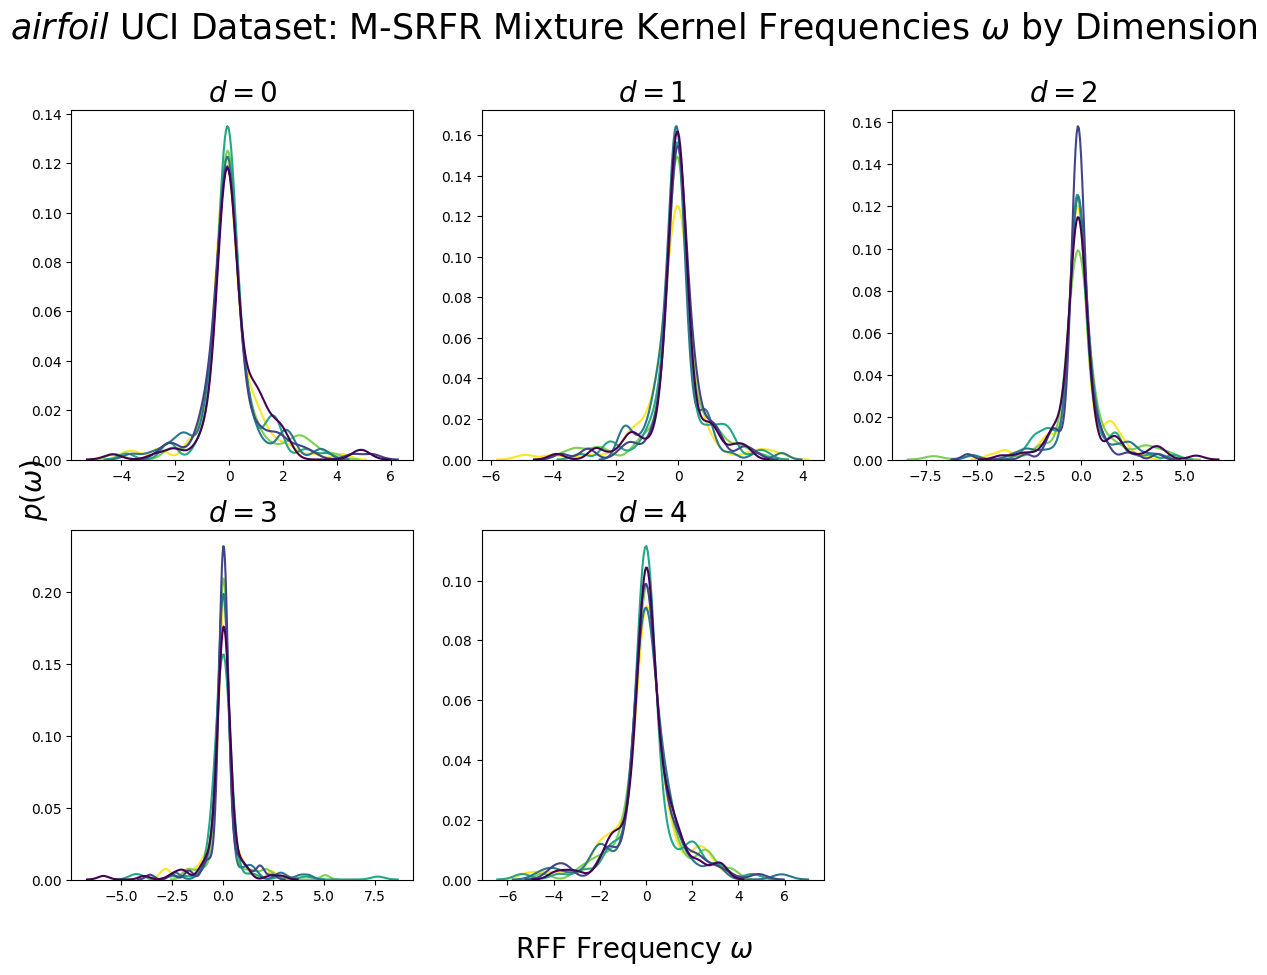

In [18]:
kernel_plot = plot_kernel_mixture(
    mix_gp.kernel.kernel.w, plots_per_row=3, bw_adjust=0.7, 
    title="$\\it{airfoil}$ UCI Dataset: M-SRFR Mixture Kernel Frequencies $\omega$ by Dimension"
)
kernel_plot.savefig("../figures/airfoil_kernel.pdf", bbox_inches="tight", dpi=300, format="pdf")

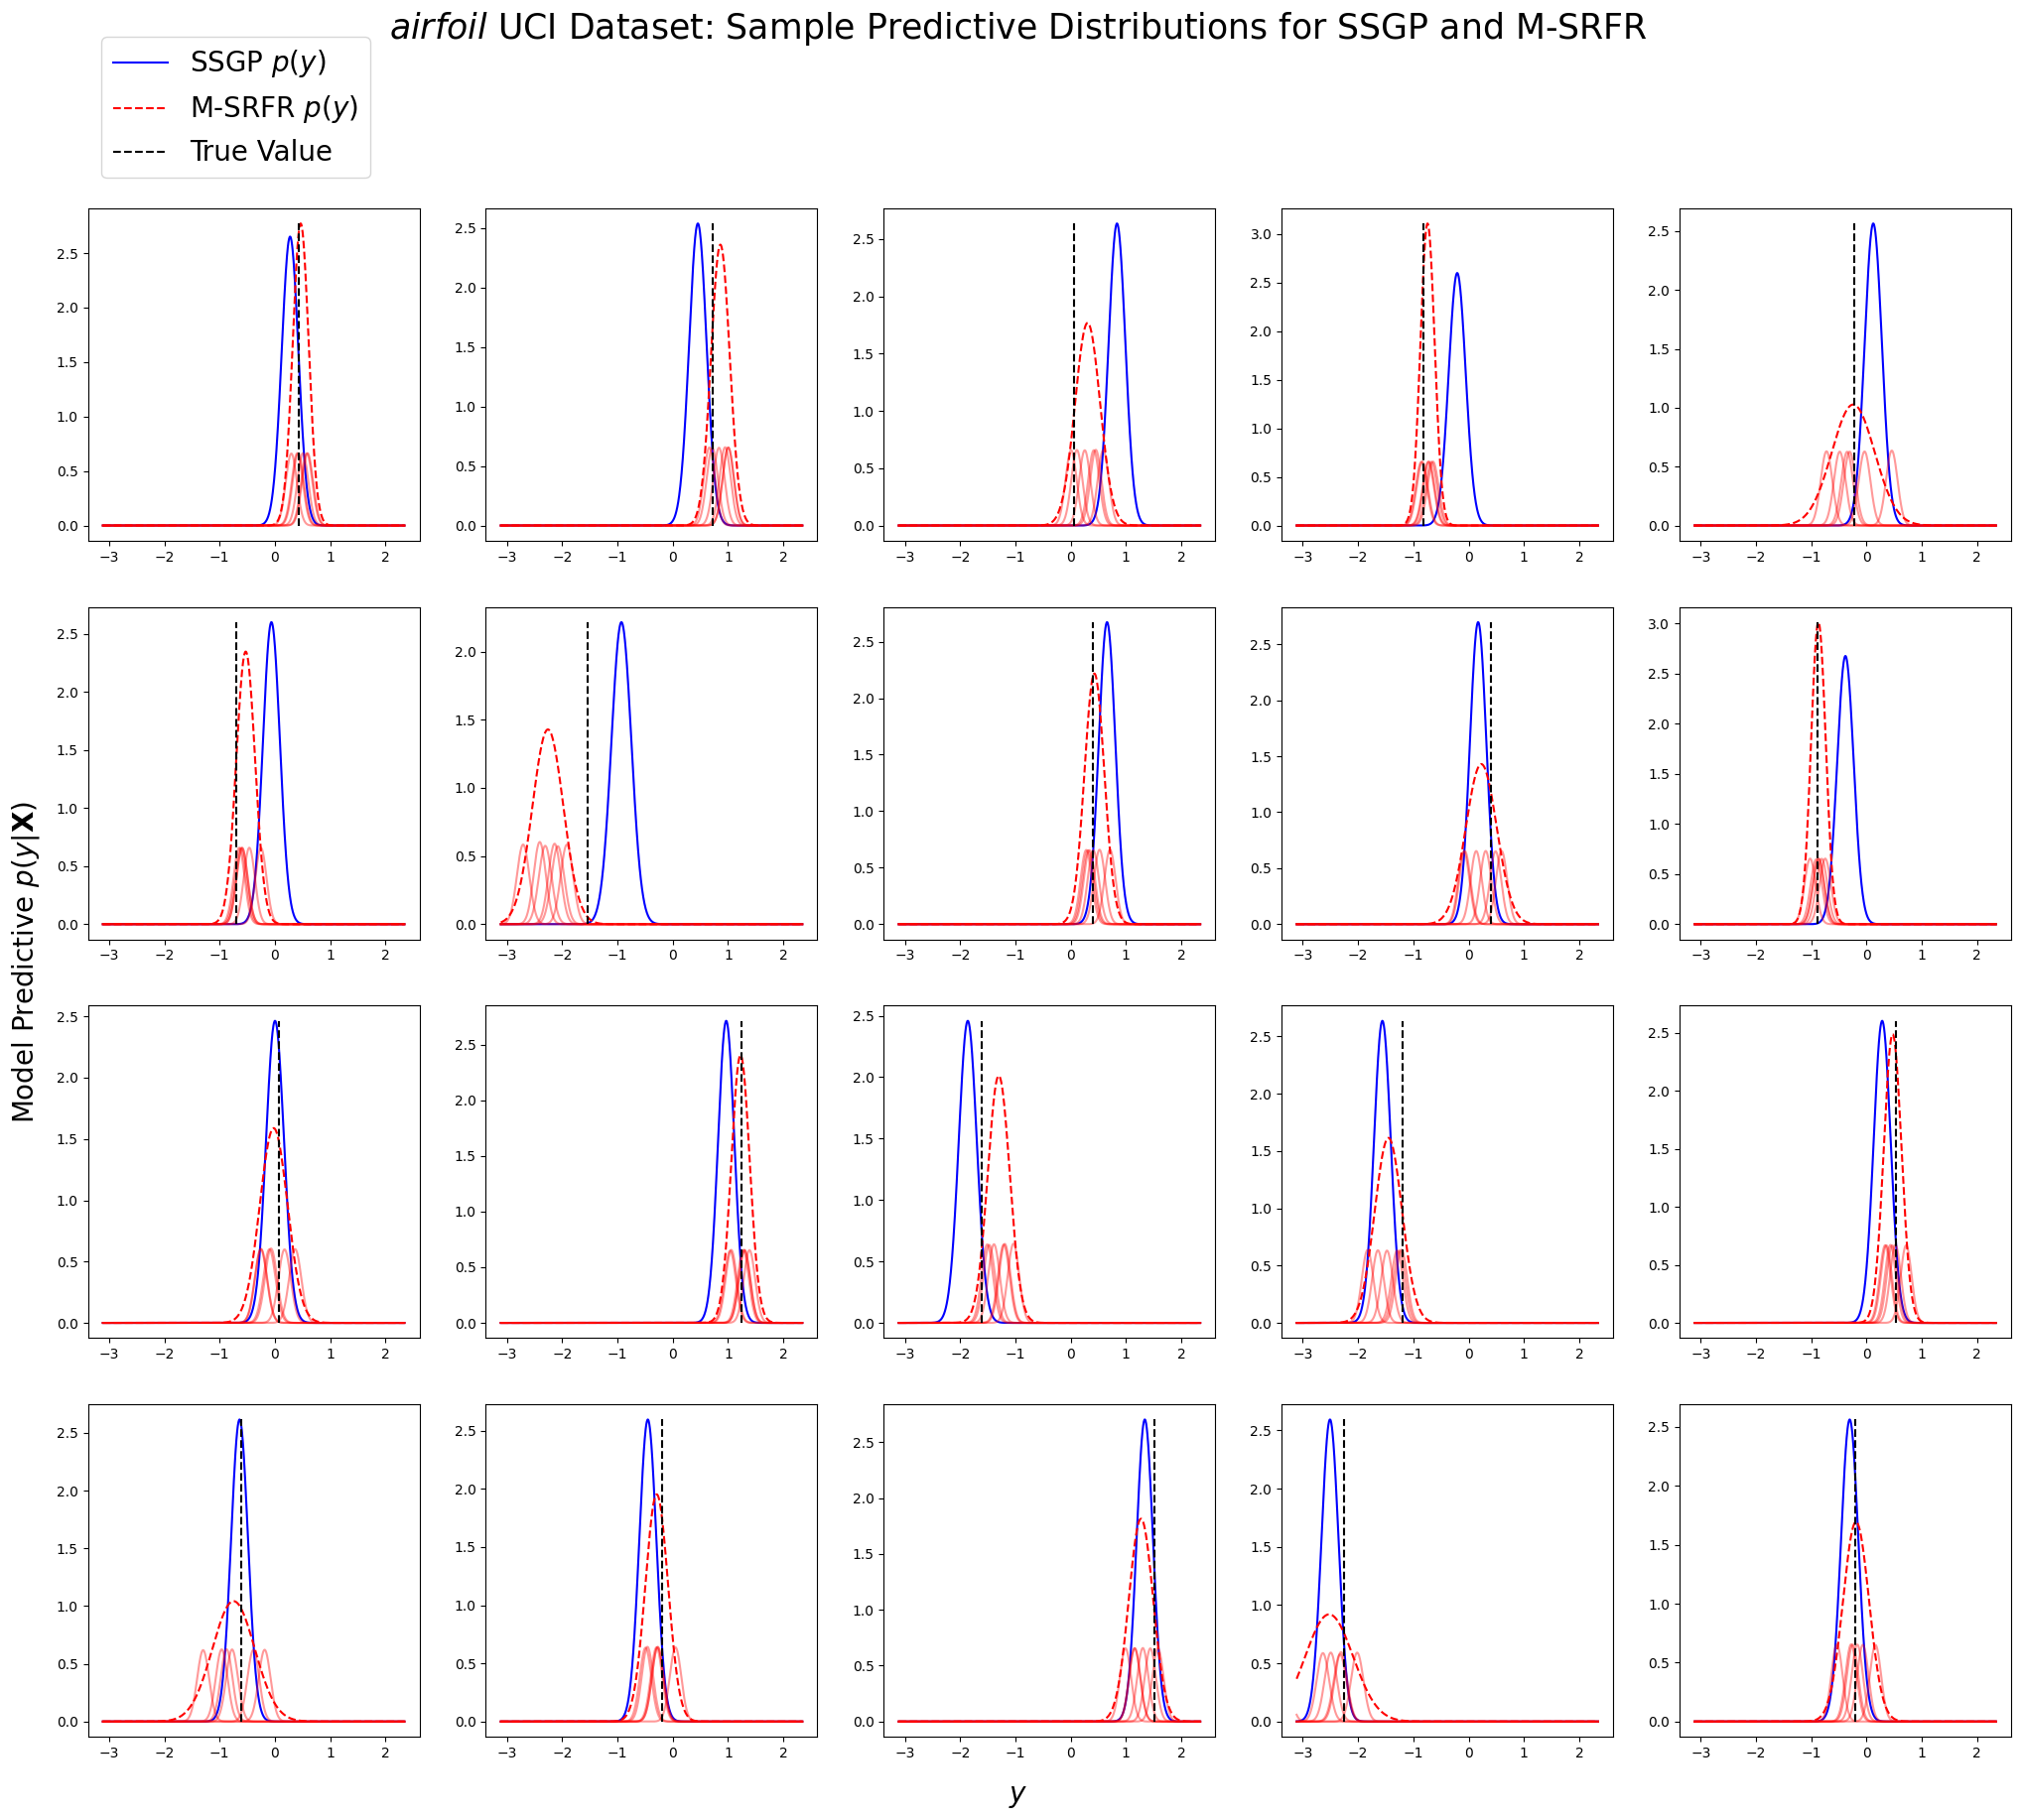

In [20]:
plot_key = jax.random.PRNGKey(2024)
plot_bounds = jnp.array([y.min(), y.max()])
pred_plot = plot_mixture_preds(
    single_dist, mixture_dist, y_test, n=20, 
    key=plot_key, standardize=False, bounds=plot_bounds,
    title="$\\it{airfoil}$ UCI Dataset: Sample Predictive Distributions for SSGP and M-SRFR"
)
pred_plot.savefig("../figures/airfoil_preds.pdf", bbox_inches="tight", dpi=300, format="pdf")